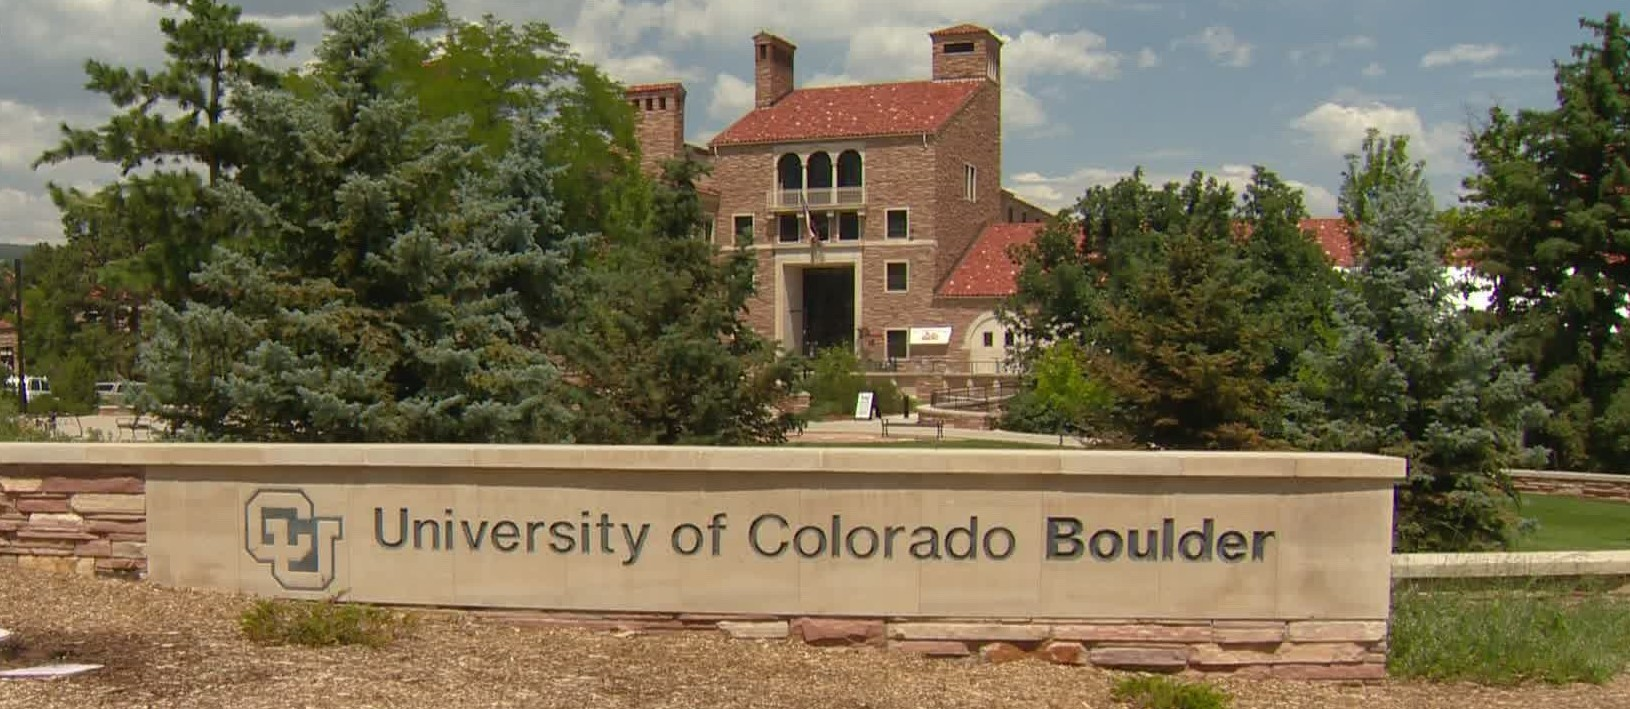

This notebook was build based on [TPS Feb 2022 | EDA | ExtraTrees](https://www.kaggle.com/devsubhash/tps-feb-2022-eda-extratrees)

# Topic

This jupyter notebook is the final project of the University of Colorado Boulder Master of Science in Data Science courese DTSA-5509 - Introduction to Machine Learning Supervised Learning

In this notebook I mainly tried to use technics which where part of the course, namely random forrest and support vector maschines. I tried to dive a little deeper in specificly theses two types for multi class classification problems. My interrest was also to compare accuracy and computational performance and how well they performe on bigger datasets.

Finally I also made an attemd with a deep neural network based on tensorflow keras on teh same problem.

As problem and data I choose the Kaggle February 2022 Tabular Playground Series competition. The task is to classify 10 different bacteria species using data from a genomic analysis technique. The source data is the frequency of the base DNA Blocks A (Adenosine), G (Guanine), C (Cytosine) and T (Thymidine). So the full sequence is not knows and the model has to work with some lossy data to predict the correct bacteria.

## Data
The idea behind the problem as well as the data is based on Ryan L. Wood, Tanner Jensen, Cindi Wadsworth, Mark Clement, Prashant Nagpal and William G. Pitts paper "[Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full)".

Into the data where simulated measurement errors added by the kaggle team to make the problem  more chalanging.

The final test and train data could be found at [Kaggle competition page](https://www.kaggle.com/c/tabular-playground-series-feb-2022/data)

## Importing libraries

In [90]:
import pandas as pd
import numpy as np

# for performace patch
#from sklearnex import patch_sklearn
##patch_sklearn() # withe larger no of trees kernel dies
 
# disable  patching
#from sklearnex import unpatch_sklearn
#unpatch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

from time import time

from sklearn import metrics

from sklearn.preprocessing import LabelEncoder # To encode string labels into numeric values
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier # Load random forest classifier 

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

import joblib # For saving the trained model
import tensorflow as tf
import os

## Importing data, cleaning and analysis

### Import data and get first overview

I downloaded the data locally and saved it into my workdir of the project. Train and testset together has alsmost size of 2 Gigabyte. So be aware if you download and run the models.

In [91]:
df_train = pd.read_csv('train.csv', index_col='row_id')
df_test  = pd.read_csv('test.csv', index_col='row_id')
df_subm = pd.read_csv("sample_submission.csv")

In [92]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 200000
Total number of columns: 287


In [93]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total number of rows:', df_test_row_count)
print('Total number of columns:', df_test_column_count)

Total number of rows: 100000
Total number of columns: 286


In [94]:
df_subm_row_count, df_subm_column_count=df_subm.shape
print('Total number of rows:', df_subm_row_count)
print('Total number of columns:', df_subm_column_count)

Total number of rows: 100000
Total number of columns: 2


In [95]:
df_train.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
row_id,,,,,,,,,,,,,,,,,,,,,
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [96]:
df_test.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
row_id,,,,,,,,,,,,,,,,,,,,,
200000,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,-0.000008,...,0.000039,0.000085,0.000055,0.000108,0.000090,0.000059,0.000010,0.000006,0.000027,4.632568e-08
200001,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,0.001800,-0.000240,0.001800,-0.000114,0.000957,-0.000010,...,-0.000043,0.000914,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07
200002,4.632568e-08,0.000003,8.465576e-08,-0.000014,0.000007,-0.000005,-0.000004,0.000003,0.000004,-0.000008,...,0.000041,0.000102,0.000084,0.000111,0.000117,0.000070,0.000020,0.000030,0.000021,4.632568e-08
200003,-9.536743e-07,-0.000008,8.084656e-06,0.000216,0.000420,0.000514,0.000452,0.000187,-0.000005,-0.000008,...,0.000069,0.000158,0.000098,0.000175,0.000217,0.000150,0.000018,0.000016,0.000051,-9.536743e-07
200004,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,0.000914,-0.000043,-0.000010,-0.000010,0.000990,-9.536743e-07


In [97]:
df_subm.head()

,row_id,target
0,200000,Streptococcus_pneumoniae
1,200001,Streptococcus_pneumoniae
2,200002,Streptococcus_pneumoniae
3,200003,Streptococcus_pneumoniae
4,200004,Streptococcus_pneumoniae


In [98]:
target_class = pd.DataFrame({'count': df_train.target.value_counts(),
                             'percentage': df_train['target'].value_counts() / df_train.shape[0] * 100
})
target_class

,count,percentage
Bacteroides_fragilis,20139,10.0695
Streptococcus_pyogenes,20076,10.0380
Streptococcus_pneumoniae,20074,10.0370
Campylobacter_jejuni,20063,10.0315
Salmonella_enterica,20030,10.0150
Escherichia_coli,19958,9.9790
Enterococcus_hirae,19947,9.9735
Escherichia_fergusonii,19937,9.9685
Staphylococcus_aureus,19929,9.9645
Klebsiella_pneumoniae,19847,9.9235


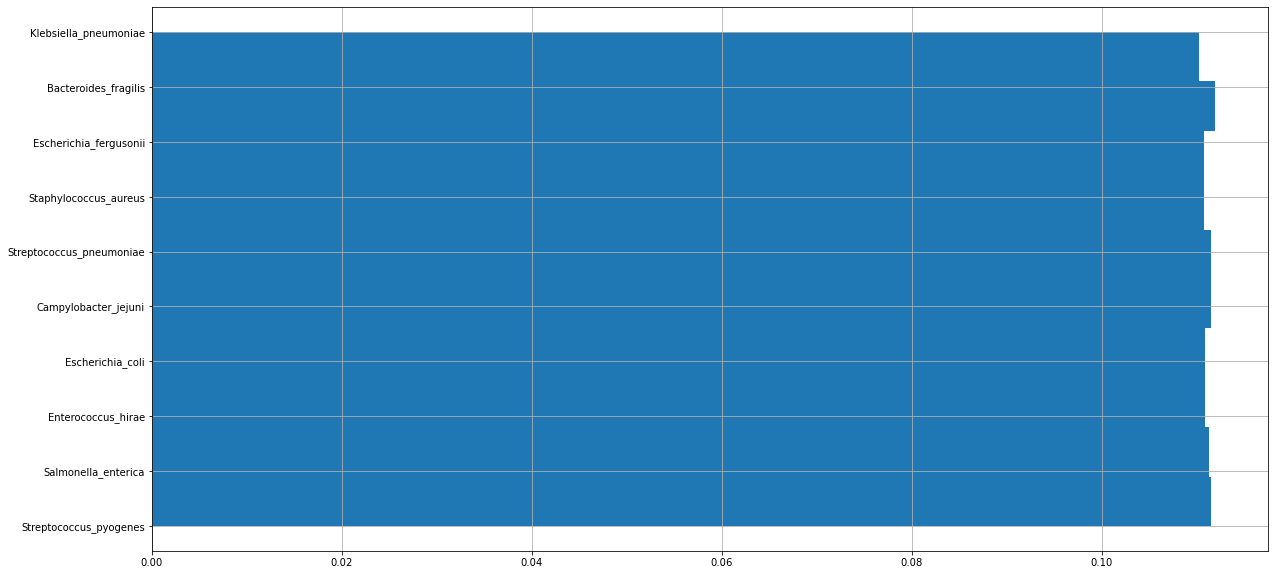

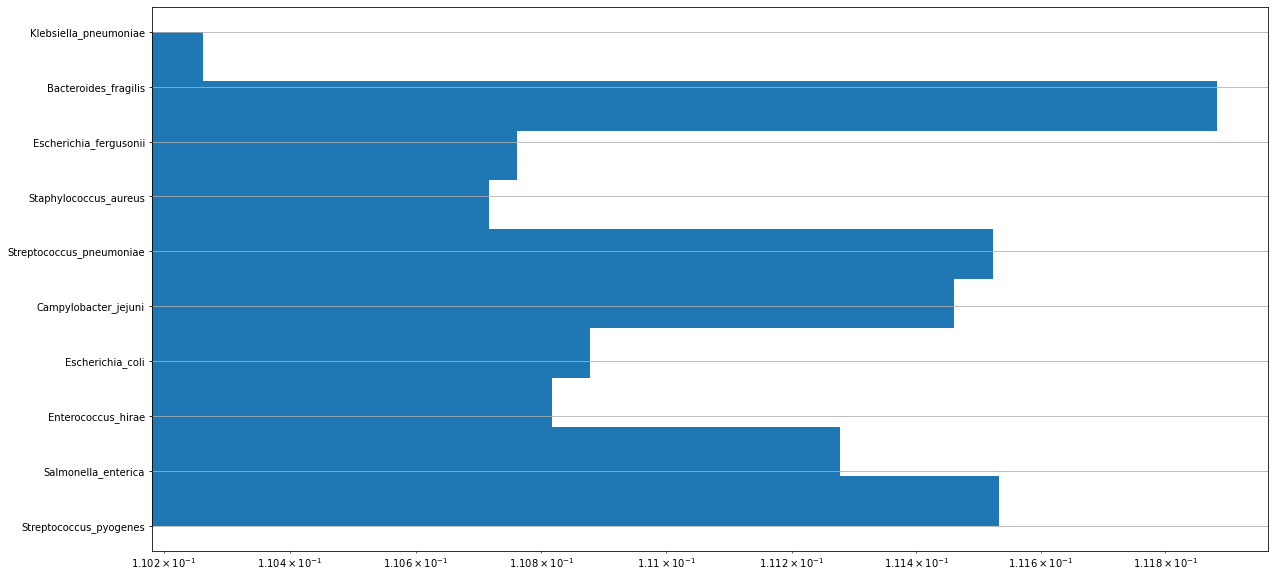

In [99]:
# increase size of plots
plt.rcParams["figure.figsize"] = (20,10)

# create a histogramm
plt.hist(df_train.target, density=True, orientation='horizontal')
plt.grid(True)
plt.show()


# to visulize the difference better use also a log scale
plt.hist(df_train.target, density=True, orientation='horizontal', log=True)
plt.grid(True)
plt.show()

In [100]:
# create correlation matrix
corr = df_train.corr()
corr

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
A0T0G0C10,1.000000,-0.000668,-0.001438,-0.003359,-0.002266,-0.001151,-0.003384,0.002306,-0.001764,-0.000283,...,0.001406,0.035986,-0.001973,0.000583,0.000571,-0.000150,0.000835,0.000289,0.002480,-0.000850
A0T0G1C9,-0.000668,1.000000,0.000018,0.003200,0.002519,0.000618,0.003464,0.008319,-0.000554,-0.000561,...,-0.002181,-0.008851,-0.007216,-0.011469,-0.007192,-0.009523,-0.004690,-0.005256,-0.004585,-0.001549
A0T0G2C8,-0.001438,0.000018,1.000000,0.088412,0.060144,0.023778,0.020243,0.016196,0.009146,-0.000500,...,-0.015640,-0.024095,-0.020421,-0.028268,-0.027821,-0.022408,-0.008022,-0.012159,-0.011668,-0.003477
A0T0G3C7,-0.003359,0.003200,0.088412,1.000000,0.119712,0.173624,0.125264,0.085270,0.053888,0.006604,...,-0.032348,-0.048383,-0.040132,-0.065379,-0.067512,-0.055962,-0.021595,-0.030539,0.007061,-0.008799
A0T0G4C6,-0.002266,0.002519,0.060144,0.119712,1.000000,0.188869,0.279435,0.125576,0.086914,0.000772,...,-0.042662,-0.070349,-0.062307,-0.084116,-0.088221,-0.071982,-0.030779,-0.039987,-0.021889,-0.011281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A8T2G0C0,-0.000150,-0.009523,-0.022408,-0.055962,-0.071982,-0.058975,-0.037449,-0.022049,-0.029873,-0.003830,...,0.099454,0.108393,0.096411,0.094497,0.153451,1.000000,0.055610,0.063172,0.094194,0.017638
A9T0G0C1,0.000835,-0.004690,-0.008022,-0.021595,-0.030779,-0.029835,-0.029315,-0.026245,-0.012286,-0.002189,...,0.108894,0.044028,0.023639,0.038471,0.084348,0.055610,1.000000,0.046002,0.024343,0.000834
A9T0G1C0,0.000289,-0.005256,-0.012159,-0.030539,-0.039987,-0.041230,-0.039232,-0.029629,-0.012845,-0.002627,...,0.015554,0.086692,0.044643,0.067773,0.032307,0.063172,0.046002,1.000000,0.020948,0.019813
A9T1G0C0,0.002480,-0.004585,-0.011668,0.007061,-0.021889,-0.029368,-0.005358,-0.028037,-0.015938,-0.002208,...,0.032748,0.062256,0.025446,0.065381,0.116588,0.094194,0.024343,0.020948,1.000000,0.004196


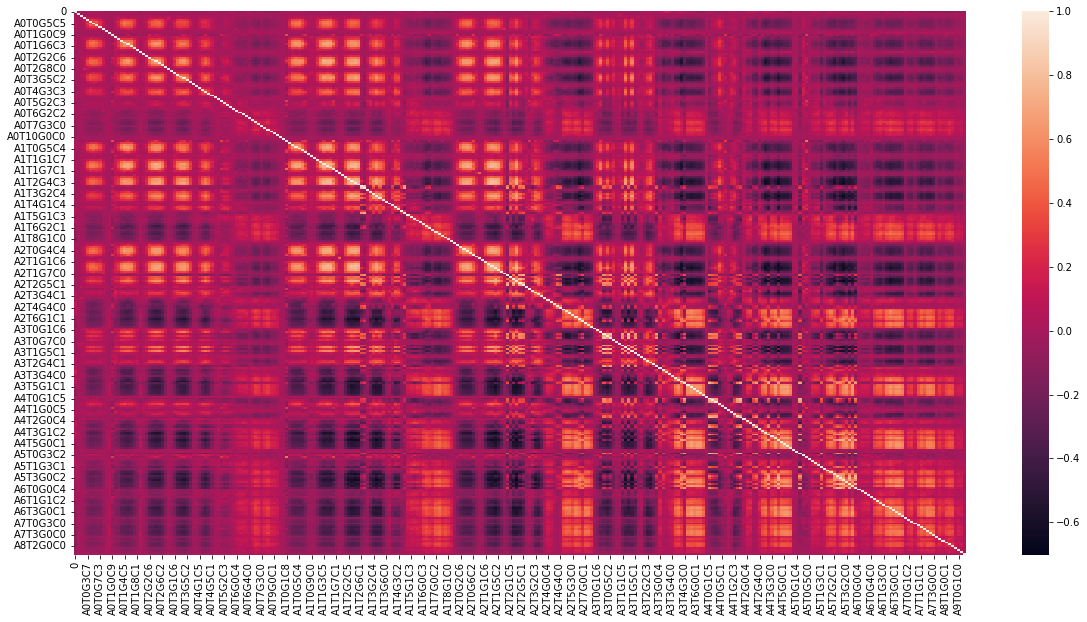

In [137]:
# plotting correlation heatmap
sns.heatmap(corr)
  
# displaying heatmap
plt.show()

Source data consits of of three files

- train.csv
- test.csv
- sample_submission.csv

Train data contains 200000 rows and 287 columns. 286 feature coloumns with the frequence of the possible DNA messurements as float and one column "target" with the ground truth of the bactery name as string.

The possible 10 bacterias are:

- Bacteroides_fragilis 	
- Streptococcus_pyogenes 	
- Streptococcus_pneumoniae 	
- Campylobacter_jejuni 	
- Salmonella_enterica 	
- Escherichia_coli
- Enterococcus_hirae
- Escherichia_fergusonii 	
- Staphylococcus_aureus 	
- Klebsiella_pneumoniae

and the frequency is alsmost equal distributed between 9.9% and 10.1%.

There are some correleted features and some pattern within the correlation heatmap are visible.

Test data contains 100000 rows and 286 columns. It alsco contains the 286 features but no targed value.

sample_submission is just a sample file how the Kaggle submission should look like and consits of 100000 rows and 2 columns, one with the ID and and one for the predicted bacteria.

### Further analysis and cleaning

In [102]:
# Verify size and data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Columns: 287 entries, A0T0G0C10 to target
dtypes: float64(286), object(1)
memory usage: 439.5+ MB


In [103]:
# check distribution and min max values
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
A0T0G0C10,200000.0,6.421457e-07,0.000087,-9.536743e-07,-9.536743e-07,-9.536743e-07,-9.536743e-07,0.009999
A0T0G1C9,200000.0,-3.076578e-06,0.000132,-9.536743e-06,-9.536743e-06,-9.536743e-06,-2.536743e-06,0.009990
A0T0G2C8,200000.0,-1.429921e-05,0.000287,-4.291534e-05,-4.291534e-05,-4.291534e-05,-1.291534e-05,0.009957
A0T0G3C7,200000.0,-9.734323e-06,0.000436,-1.144409e-04,-1.144409e-04,-1.144409e-04,-4.440918e-06,0.009886
A0T0G4C6,200000.0,4.910864e-06,0.000683,-2.002716e-04,-2.002716e-04,-2.002716e-04,-1.127161e-05,0.019800
...,...,...,...,...,...,...,...,...
A8T2G0C0,200000.0,3.792137e-04,0.001182,-4.291534e-05,-4.291534e-05,4.308466e-05,3.650847e-04,0.019957
A9T0G0C1,200000.0,6.172008e-05,0.000466,-9.536743e-06,-9.536743e-06,-9.536743e-06,3.046326e-05,0.009990
A9T0G1C0,200000.0,8.982134e-05,0.000548,-9.536743e-06,-9.536743e-06,4.632568e-07,6.046326e-05,0.009990
A9T1G0C0,200000.0,1.170014e-04,0.000679,-9.536743e-06,-9.536743e-06,4.632568e-07,6.946326e-05,0.019990


In [104]:
# check distribution and min max values
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
A0T0G0C10,100000.0,6.635157e-07,0.000075,-9.536743e-07,-9.536743e-07,-9.536743e-07,-9.536743e-07,0.009999
A0T0G1C9,100000.0,-2.069683e-06,0.000158,-9.536743e-06,-9.536743e-06,-9.536743e-06,-1.536743e-06,0.009990
A0T0G2C8,100000.0,-1.670571e-05,0.000254,-4.291534e-05,-4.291534e-05,-4.291534e-05,-1.291534e-05,0.009957
A0T0G3C7,100000.0,-9.132418e-06,0.000443,-1.144409e-04,-1.144409e-04,-1.144409e-04,-4.440918e-06,0.009886
A0T0G4C6,100000.0,1.653384e-06,0.000664,-2.002716e-04,-2.002716e-04,-1.982716e-04,-1.027161e-05,0.019800
...,...,...,...,...,...,...,...,...
A8T2G0C0,100000.0,3.918431e-04,0.001200,-4.291534e-05,-4.291534e-05,4.608466e-05,3.670847e-04,0.019957
A9T0G0C1,100000.0,6.034977e-05,0.000444,-9.536743e-06,-9.536743e-06,-9.536743e-06,3.146326e-05,0.009990
A9T0G1C0,100000.0,9.343461e-05,0.000578,-9.536743e-06,-9.536743e-06,4.632568e-07,6.046326e-05,0.009990
A9T1G0C0,100000.0,1.198191e-04,0.000676,-9.536743e-06,-9.536743e-06,4.632568e-07,7.046326e-05,0.019990


### Check for missing values

In [105]:
df_train.isna().sum()

A0T0G0C10    0
A0T0G1C9     0
A0T0G2C8     0
A0T0G3C7     0
A0T0G4C6     0
            ..
A9T0G0C1     0
A9T0G1C0     0
A9T1G0C0     0
A10T0G0C0    0
target       0
Length: 287, dtype: int64

In [106]:
sum(df_train.isna().sum())

0

In [107]:
df_test.isna().sum()

A0T0G0C10    0
A0T0G1C9     0
A0T0G2C8     0
A0T0G3C7     0
A0T0G4C6     0
            ..
A8T2G0C0     0
A9T0G0C1     0
A9T0G1C0     0
A9T1G0C0     0
A10T0G0C0    0
Length: 286, dtype: int64

In [108]:
sum(df_train.isna().sum())

0

We have no NA values in the test or train set.. This is already known from the description of the dataset but here just to verify and chrosscheck

### Check for unique values

In [109]:
print ("Unique values are:\n",df_train.nunique())
print ("Max unique values are:\n",max(df_train.nunique()))

Unique values are:
 A0T0G0C10      18
A0T0G1C9       23
A0T0G2C8      139
A0T0G3C7      683
A0T0G4C6     1279
             ... 
A9T0G0C1      354
A9T0G1C0      509
A9T1G0C0      515
A10T0G0C0      22
target         10
Length: 287, dtype: int64
Max unique values are:
 12494


Dataset has 10 taget unique values as we already know. The features has up to 12494 unique values.

### Check for duplicate entries

In [110]:
# check for duplicate entries
print("duplicate entries in trainset:",df_train.duplicated().sum())
print("duplicate entries in testset:",df_test.duplicated().sum())


duplicate entries in trainset: 76007
duplicate entries in testset: 26779


Train as well as testset has duplicate entries. In testset we will keep these entries for correct prediction. In testset we could drop the duplicate entries because they will give us no additional information.

In [111]:
# drop duplicate entries in train set
df_train = df_train.drop_duplicates()

In [112]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 123993
Total number of columns: 287


After data cleaning we are left with 123993 unique rows in testset with one taget value and 286 features. We have no NA or missing values.

### Create dataframes for ground truth (y) and features (X)

In [114]:
#Defining X and y
X = df_train.drop(['target'], axis=1)
y = df_train['target']

### Encode the string target labels into numeric values

In [115]:
# encode the targed labels from string into numeric
enc = LabelEncoder()
y = enc.fit_transform(y)

### Split dataset for training and internal testing

In [8]:
# creating dataset split for prediction
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (160000, 286)
y_train: (160000,)
X_test: (40000, 286)
y_test: (40000,)


## Random Forest Classifier

First approach is to use a random forrest classifier.

### Model selection

To find propper parameters I used parameter tuning via GridSearch with cross validation. I tried different combinations for the number of trees, the minimum sample split size, minimum number of sample leafgs and ccp alpha for pruning.

If you run the notebook please be aware that this will take a very long time dependingn on your hardware.

I did this comparisons and parameter tuning iterative and in severals runs. Therfore I have no homogenius output or nice plots. I summarized the results below which lead to the final model.

Beside grid search I also tried differend values for out of bag and maximum depth. Result was default values without limiting the depth of the tree or using out of bag has highes accuray in this case.

In [108]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'n_estimators':list(range(500,2001,500)), 'min_samples_split':list(range(2,11,2)), "min_samples_leaf":list(range(1,11,2))}

rf =  RandomForestClassifier(
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    max_leaf_nodes = None,
    bootstrap=True,  # bootstrap samples 
    oob_score=True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)


grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [23]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9588500000000002

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}

In [108]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'n_estimators':list(range(1500,2501,500))}

rf =  RandomForestClassifier(
    n_jobs=-1,
    min_samples_split = 2,
    min_samples_leaf = 1,
    random_state=42, 
    max_depth = None, #10
    max_leaf_nodes = None,
    bootstrap=True,  # bootstrap samples 
    oob_score=True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [23]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9495750368110484

Best parameters: {'n_estimators': 2500}

In [108]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.1,1.1,0.1))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [23]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

In [108]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.logspace(np.log(0.0005), np.log(0.005), 10))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [23]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

In [108]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.000001, 0.00001, 0.000001))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(X_train, y_train)

In [23]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
print(grid.cv_results_)
print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.1007500000469333

Best parameters: {'ccp_alpha': 1}


Best Score: 0.1007500000469333

Best parameters: {'ccp_alpha': 0.1}


Best Score: 0.9898062519132541

Best parameters: {'ccp_alpha': 0}


Best Score: 0.7890999915460762

Best parameters: {'ccp_alpha': 0.0010098752448723196}


Best Score: 0.9898187523429399

Best parameters: {'ccp_alpha': 9.068290445501951e-06}


Best Score: 0.9898062519132541

Best parameters: {'ccp_alpha': 2.5066721763645345e-08}


### Results of Random forrest parameter tuning

Summary of parameter tuning was that a ccp_alpha of 0, min_samples_leaf of 1, min_samples_split of 2 and a high number of trees will lead to the highest accuracy of the model

Based on this outcome I created the final model. I increased iterativly the number of trees and verified on testset as well as on the final Kaggle prediction that accuracy still increase.

The accuracy was increasing until the maximum number of trees was reached that my hardware was able to compute without memmory issues.

### Final Model

In [ ]:
#Create a final random forest Classifier
mrf = RandomForestClassifier(
    n_estimators=35000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, 
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=False, # For grid Search
    max_samples=None, # None = All 
    ccp_alpha=0,#9*10**-6    #Minimal Cost-Complexity Pruning
    verbose=1 # Enable massages during fit and predict (Level 2 shows every tree)
)

Because the model training with such a big dataset of almost 200000 rows, 286 feature and 35000 trees take quite long I was experimenting with saving the trained model to file to be able to load it again without the need of training.

Next cell is for loading a trained model from file.

In [26]:
filename = "35000trees_random_forest.joblib"

# load already trained saved model, no need to initialize
mrf = joblib.load(filename)

### final training on full data
After I selected the model with best performance I started training on full dataset. Remember I splited the dataset 80/20 for train and test before but for final training I use the full dataset and prediction is on the Kaggle testset.

In [109]:
t0_full = time() # Start time for training
    
# Train model with full dataset
mrf.fit(X, y)
    
# End time for training
rf_time_train_full=time() - t0_full

print('Training time', rf_time_train_full)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 7152 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 8402 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 11202 tasks 

MemoryError: could not allocate 1835008 bytes

Here some trainign times for the full dataset. As we see the training time is almost linear to the number of trees.

full train set rf with 10000 trees:

Training time 1467.8956661224365


full train set rf with 25000 trees:

Training time 3850.133116722107

To be able to load the trained model again I saved it to file.

In [197]:
# save trained model to file
filename = str(time())+"35000trees_random_forest.joblib"
joblib.dump(mrf, filename, compress=3)

['1644777199.963368235000trees_random_forest.joblib']

### Final prediction on Kaggle Testset

In [ ]:
# Make final prediction random forest
y_submit = mrf.predict(df_test)

## Suport Vector Machine

Next step I would like to evaluate is the performance of Suport Vector Machines with a one versus all classifier for the 10 different bacteria.

Because I need the OneVsRestClassifier wrapper (gridsearch is not working then) and the only relevant parameter to tune was C I decided to compare different values just with a for loop and compare resulting accuracy and training time.

In [179]:
t0 = time() # Start time for training
# Train the Classifier/fitting the model
mrf.fit(X_train, y_train)
rf_time_train=time() - t0

# predict the response
y_pred = mrf.predict(X_test)
rf_time_predict=time() - t0 - rf_time_train
#acc_rf = round(mrf.score(X_test,y_test) * 100, 2)

# evaluate accuracy
print("Random Forest Classifier Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Random Forest Classifier Training time', rf_time_train)
print('Random Forest Classifier Prediction time', rf_time_predict)

#Print Confusion Matrix
#from sklearn.metrics import confusion_matrix

#cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
#sns.heatmap(cm, annot=True,cmap=custom_colors)

for c in [0.1, 2, 3.5, 5, 7, 10, 20, 100, 200, 500, 1000, 10000]:
    ova_t0 = time() # Start time for training
    ovasvm = OneVsRestClassifier(SVC(C=c), n_jobs = -1).fit(X_train, y_train)
    ova_time_train=time() - ova_t0

    y_pred_ova = ovasvm.predict(X_test)
    ova_time_predict=time() - ova_t0 - ova_time_train

    # evaluate accuracy
    print("One vs. All SVM Accuracy:",metrics.accuracy_score(y_test, y_pred_ova), "C:", c)
    print('One vs. All SVM Training time', ova_time_train)
    print('One vs. All SVM Prediction time', ova_time_predict)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 7152 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 8402 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 11202 tasks 

Random Forest Classifier Accuracy: 0.9782652526311545
Random Forest Classifier Training time 1808.7973141670227
Random Forest Classifier Prediction time 362.5303328037262


[Parallel(n_jobs=24)]: Done 35000 out of 35000 | elapsed:  6.0min finished


SVM C 0.1

One vs. All SVM Accuracy: 0.912525

One vs. All SVM Training time 201.67318201065063

One vs. All SVM Prediction time 17.121339797973633



SVM C 5

One vs. All SVM Accuracy: 0.9677

One vs. All SVM Training time 307.69044399261475

One vs. All SVM Prediction time 7.050654888153076


SVM C 2

One vs. All SVM Accuracy: 0.9618

One vs. All SVM Training time 275.2420449256897

One vs. All SVM Prediction time 9.083268404006958

SVM C 10

One vs. All SVM Accuracy: 0.9674

One vs. All SVM Training time 325.32675409317017

One vs. All SVM Prediction time 6.328017950057983

SVM C 3.5

One vs. All SVM Accuracy: 0.96665

One vs. All SVM Training time 282.0221161842346

One vs. All SVM Prediction time 8.043567180633545


One vs. All SVM Accuracy: 0.96665 C: 7

One vs. All SVM Accuracy: 0.97035 C: 15

One vs. All SVM Training time 341.140483379364

One vs. All SVM Prediction time 5.618558406829834

One vs. All SVM Accuracy: 0.974675 C: 20

One vs. All SVM Training time 351.71434783935547

One vs. All SVM Prediction time 5.1889519691467285

One vs. All SVM Accuracy: 0.97645 C: 100

One vs. All SVM Training time 430.5154676437378

One vs. All SVM Prediction time 3.756833553314209

One vs. All SVM Accuracy: 0.975125 C: 200

One vs. All SVM Training time 455.3629403114319

One vs. All SVM Prediction time 3.254791021347046

One vs. All SVM Accuracy: 0.972225 C: 500

One vs. All SVM Training time 513.377783536911

One vs. All SVM Prediction time 2.9232218265533447

One vs. All SVM Accuracy: 0.977575 C: 1000

One vs. All SVM Training time 566.6204144954681

One vs. All SVM Prediction time 2.5607399940490723

One vs. All SVM Accuracy: 0.9748 C: 10000

One vs. All SVM Training time 622.2721812725067

One vs. All SVM Prediction time 2.186563014984131

### Final model training on full data

The dafault model had the best accuracy in theis case. So I startet training also this model on full dataset.

Because SVM could not be parallelized as easy as random forrest. Herer every tree could be build in a own tread. I experimented with performance tuning.

I found the sklearnex library from intel to tune the performance of sklearn functions. Even if I used a AMD CPU I was able to speed up the SVM by more as factor 25. So without patching sklearn SVM training took 6868 seconds (alsmost 2 hours) per run and after the patch training used all availble treads and more memory and training time was reduced to only 272 seconds!

For randmom forrest there was no performace improvement but more memory where used and the system become instable. Therefore the library is not used at the moment. But it is still in the comments in library section above.

In [29]:
ova_t0_full = time() # Start time for training
    
# Train model with full dataset
ovasvm = OneVsRestClassifier(SVC()).fit(X, y)
    
# End time for training
ova_time_train_full=time() - ova_t0_full

print('Training time', ova_time_train_full)
    
# save trained model to file
filename = str(time())+"_ova.joblib"
joblib.dump(ovasvm, filename, compress=3)

In [199]:
# Make final prediction OVA
y_test = ovasvm.predict(df_test.drop(columns='row_id',inplace=False))

### Comparison accuracy Random Forrest with SVM one vs All

As the results show, in this case a random forrest with 500 trees is already superior compared to SVM One vs. All. Therefore I concentrated on the randeom forrest. By the way also the training of the forrest was faster as for the SVM

RF 500 trees vs OvA_SVM with sklearnex

Random Forest Classifier Accuracy: 0.99475

Random Forest Classifier Training time 60.175848722457886

Random Forest Classifier Prediction time 0.9152729511260986

One vs. All SVM Accuracy: 0.95295

One vs. All SVM Training time 272.09899830818176

One vs. All SVM Prediction time 10.903482913970947

## Deep neural network

As last technics I tried to create deep neural network with tensorflow and a sequencial keras model. Here I experimented a lot with different layers, number of neurons, regularisations and dropouts.

Also it took some time until training performance was good and tensorflow was working with my grafics card.

Below is the final model I used. We have some dense layers with decreasing number of neurons. Some use L2 regularisations and some are followed by dropout layers to make model more robust and prevent from overfitting.

Las layer use a softmax activation to create the predictions for our 10 classes (bacterias).

In [91]:
# Create tensorflow Model
tf.keras.regularizers.l2(l2=0.001)

model = tf.keras.models.Sequential([
  tf.keras.Input(shape=286),
  tf.keras.layers.Normalization(axis=-1),
  tf.keras.layers.Dense(286, activation='relu'),#, kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(286, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(256, activation='relu'),#, kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(64, activation='relu'),#, kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2'),
  tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
# fit Model on testdata Could also be used to continue training

model.fit(tf.convert_to_tensor(X_train.values), tf.convert_to_tensor(y_train), epochs=100)


Epoch 1/100
5000/5000 [==============================] - 30s 6ms/step - loss: 1.3791 - accuracy: 0.4701
Epoch 2/100
5000/5000 [==============================] - 31s 6ms/step - loss: 1.0231 - accuracy: 0.6188
Epoch 3/100
5000/5000 [==============================] - 24s 5ms/step - loss: 0.8695 - accuracy: 0.7019
Epoch 4/100
5000/5000 [==============================] - 28s 6ms/step - loss: 0.7889 - accuracy: 0.7469
Epoch 5/100
5000/5000 [==============================] - 24s 5ms/step - loss: 0.7236 - accuracy: 0.7850
Epoch 6/100
5000/5000 [==============================] - 33s 7ms/step - loss: 0.6750 - accuracy: 0.8016
Epoch 7/100
5000/5000 [==============================] - 33s 7ms/step - loss: 0.6412 - accuracy: 0.8112
Epoch 8/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.6146 - accuracy: 0.8207
Epoch 9/100
5000/5000 [==============================] - 28s 6ms/step - loss: 0.5880 - accuracy: 0.8275
Epoch 10/100
5000/5000 [==============================] - 29s 6m

5000/5000 [==============================] - 26s 5ms/step - loss: 0.2916 - accuracy: 0.9203
Epoch 80/100
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2921 - accuracy: 0.9186
Epoch 81/100
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2875 - accuracy: 0.9206
Epoch 82/100
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2881 - accuracy: 0.9208
Epoch 83/100
5000/5000 [==============================] - 26s 5ms/step - loss: 0.2859 - accuracy: 0.9216
Epoch 84/100
5000/5000 [==============================] - 26s 5ms/step - loss: 0.2823 - accuracy: 0.9224
Epoch 85/100
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2833 - accuracy: 0.9222
Epoch 86/100
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2841 - accuracy: 0.9214
Epoch 87/100
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2839 - accuracy: 0.9225
Epoch 88/100
5000/5000 [==============================] - 26s 5ms/st

Via history the performed training losses (and therewith also the epochs) could be accessed

In [95]:
training_loss = list(model.history.history['loss'])
epochs = len(training_loss)

With this data also the trainign could be continued and a pretrained model coudl get further training.

In [97]:
# continue trainging
additional_epochs = 400

model.fit(tf.convert_to_tensor(X_train.values), tf.convert_to_tensor(y_train), epochs=epochs+additional_epochs, initial_epoch=epochs)

Epoch 101/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2705 - accuracy: 0.9258
Epoch 102/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2735 - accuracy: 0.9247
Epoch 103/500
5000/5000 [==============================] - 24s 5ms/step - loss: 0.2700 - accuracy: 0.9269
Epoch 104/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2683 - accuracy: 0.9265
Epoch 105/500
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2680 - accuracy: 0.9271
Epoch 106/500
5000/5000 [==============================] - 23s 5ms/step - loss: 0.2686 - accuracy: 0.9259
Epoch 107/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2675 - accuracy: 0.9275
Epoch 108/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2650 - accuracy: 0.9279
Epoch 109/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2691 - accuracy: 0.9267
Epoch 110/500
5000/5000 [=====================

5000/5000 [==============================] - 24s 5ms/step - loss: 0.2173 - accuracy: 0.9433
Epoch 255/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2202 - accuracy: 0.9421
Epoch 256/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2218 - accuracy: 0.9423
Epoch 257/500
5000/5000 [==============================] - 26s 5ms/step - loss: 0.2222 - accuracy: 0.9419
Epoch 258/500
5000/5000 [==============================] - 26s 5ms/step - loss: 0.2219 - accuracy: 0.9428
Epoch 259/500
5000/5000 [==============================] - 24s 5ms/step - loss: 0.2203 - accuracy: 0.9423
Epoch 260/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2166 - accuracy: 0.9432
Epoch 261/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2189 - accuracy: 0.9435
Epoch 262/500
5000/5000 [==============================] - 26s 5ms/step - loss: 0.2187 - accuracy: 0.9431
Epoch 263/500
5000/5000 [==============================] - 2

5000/5000 [==============================] - 24s 5ms/step - loss: 0.2023 - accuracy: 0.9494
Epoch 409/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2017 - accuracy: 0.9499
Epoch 410/500
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2011 - accuracy: 0.9492
Epoch 411/500
5000/5000 [==============================] - 26s 5ms/step - loss: 0.1995 - accuracy: 0.9495
Epoch 412/500
5000/5000 [==============================] - 26s 5ms/step - loss: 0.2020 - accuracy: 0.9491
Epoch 413/500
5000/5000 [==============================] - 26s 5ms/step - loss: 0.1967 - accuracy: 0.9504
Epoch 414/500
5000/5000 [==============================] - 23s 5ms/step - loss: 0.1999 - accuracy: 0.9497
Epoch 415/500
5000/5000 [==============================] - 21s 4ms/step - loss: 0.2002 - accuracy: 0.9500
Epoch 416/500
5000/5000 [==============================] - 23s 5ms/step - loss: 0.1999 - accuracy: 0.9498
Epoch 417/500
5000/5000 [==============================] - 2

Epoch 100/100
3100/3100 [==============================] - 10s 3ms/step - loss: 0.0318 - accuracy: 0.9885

In [98]:
training_loss.extend(list(model.history.history['loss']))
epochs = len(training_loss)

To check how the training proceed I plotted regular the loss agaist the number of epochs.

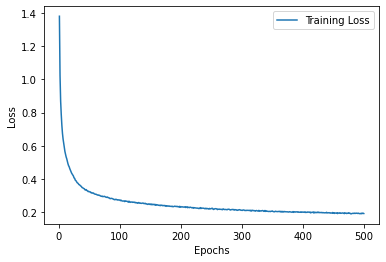

In [99]:
plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [63]:
# Check if GPU is present and configured for tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Evaluate model an train data
model.evaluate(tf.convert_to_tensor(X_test.values), tf.convert_to_tensor(y_test))

model.summary()

Num GPUs Available:  1
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0958 - accuracy: 0.9847
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 286)              573       
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 286)               82082     
                                                                 
 dense_21 (Dense)            (None, 286)               82082     
                                                                 
 dense_22 (Dense)            (None, 256)               73472     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense

### Final model training on full data

Also the neural nbetwork was trained on the full dataset. In this case in total I trained it for 1500 epochs and loss was still decreasing.

In [100]:
# fit Model on full data
model.fit(tf.convert_to_tensor(X), tf.convert_to_tensor(y), epochs=1000)

#model.evaluate(tf.convert_to_tensor(X_test.values), tf.convert_to_tensor(y_test))

Epoch 1/1000
6250/6250 [==============================] - 28s 4ms/step - loss: 0.2000 - accuracy: 0.9503
Epoch 2/1000
6250/6250 [==============================] - 28s 4ms/step - loss: 0.2018 - accuracy: 0.9498
Epoch 3/1000
6250/6250 [==============================] - 28s 5ms/step - loss: 0.1984 - accuracy: 0.9510
Epoch 4/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.1980 - accuracy: 0.9504
Epoch 5/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.1959 - accuracy: 0.9514
Epoch 6/1000
6250/6250 [==============================] - 28s 4ms/step - loss: 0.1990 - accuracy: 0.9503
Epoch 7/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.2002 - accuracy: 0.9502
Epoch 8/1000
6250/6250 [==============================] - 33s 5ms/step - loss: 0.1983 - accuracy: 0.9506
Epoch 9/1000
6250/6250 [==============================] - 33s 5ms/step - loss: 0.1985 - accuracy: 0.9506
Epoch 10/1000
6250/6250 [==============================

6250/6250 [==============================] - 29s 5ms/step - loss: 0.1827 - accuracy: 0.9558
Epoch 155/1000
6250/6250 [==============================] - 33s 5ms/step - loss: 0.1835 - accuracy: 0.9554
Epoch 156/1000
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1847 - accuracy: 0.9549
Epoch 157/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1852 - accuracy: 0.9551
Epoch 158/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.1848 - accuracy: 0.9550
Epoch 159/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1839 - accuracy: 0.9549
Epoch 160/1000
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1849 - accuracy: 0.9552
Epoch 161/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1848 - accuracy: 0.9552
Epoch 162/1000
6250/6250 [==============================] - 30s 5ms/step - loss: 0.1856 - accuracy: 0.9549
Epoch 163/1000
6250/6250 [==========================

6250/6250 [==============================] - 32s 5ms/step - loss: 0.1762 - accuracy: 0.9586
Epoch 307/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1756 - accuracy: 0.9585
Epoch 308/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1770 - accuracy: 0.9577
Epoch 309/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.1758 - accuracy: 0.9583
Epoch 310/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1755 - accuracy: 0.9584
Epoch 311/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1763 - accuracy: 0.9577
Epoch 312/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1754 - accuracy: 0.9588
Epoch 313/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.1752 - accuracy: 0.9590
Epoch 314/1000
6250/6250 [==============================] - 33s 5ms/step - loss: 0.1765 - accuracy: 0.9579
Epoch 315/1000
6250/6250 [==========================

6250/6250 [==============================] - 26s 4ms/step - loss: 0.1703 - accuracy: 0.9601
Epoch 459/1000
6250/6250 [==============================] - 28s 4ms/step - loss: 0.1709 - accuracy: 0.9602
Epoch 460/1000
6250/6250 [==============================] - 33s 5ms/step - loss: 0.1706 - accuracy: 0.9600
Epoch 461/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1706 - accuracy: 0.9603
Epoch 462/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1686 - accuracy: 0.9598
Epoch 463/1000
6250/6250 [==============================] - 28s 4ms/step - loss: 0.1683 - accuracy: 0.9604
Epoch 464/1000
6250/6250 [==============================] - 33s 5ms/step - loss: 0.1699 - accuracy: 0.9599
Epoch 465/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1705 - accuracy: 0.9600
Epoch 466/1000
6250/6250 [==============================] - 28s 4ms/step - loss: 0.1738 - accuracy: 0.9599
Epoch 467/1000
6250/6250 [==========================

6250/6250 [==============================] - 32s 5ms/step - loss: 0.1641 - accuracy: 0.9619
Epoch 611/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1651 - accuracy: 0.9617
Epoch 612/1000
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1658 - accuracy: 0.9618
Epoch 613/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1669 - accuracy: 0.9614
Epoch 614/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1661 - accuracy: 0.9619
Epoch 615/1000
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1649 - accuracy: 0.9617
Epoch 616/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1654 - accuracy: 0.9615
Epoch 617/1000
6250/6250 [==============================] - 30s 5ms/step - loss: 0.1677 - accuracy: 0.9615
Epoch 618/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1648 - accuracy: 0.9617
Epoch 619/1000
6250/6250 [==========================

6250/6250 [==============================] - 27s 4ms/step - loss: 0.1616 - accuracy: 0.9634
Epoch 763/1000
6250/6250 [==============================] - 30s 5ms/step - loss: 0.1624 - accuracy: 0.9627
Epoch 764/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1627 - accuracy: 0.9626
Epoch 765/1000
6250/6250 [==============================] - 30s 5ms/step - loss: 0.1636 - accuracy: 0.9627
Epoch 766/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1612 - accuracy: 0.9633
Epoch 767/1000
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1610 - accuracy: 0.9631
Epoch 768/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1636 - accuracy: 0.9622
Epoch 769/1000
6250/6250 [==============================] - 30s 5ms/step - loss: 0.1603 - accuracy: 0.9632
Epoch 770/1000
6250/6250 [==============================] - 26s 4ms/step - loss: 0.1645 - accuracy: 0.9618
Epoch 771/1000
6250/6250 [==========================

6250/6250 [==============================] - 31s 5ms/step - loss: 0.1577 - accuracy: 0.9643
Epoch 915/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1586 - accuracy: 0.9642
Epoch 916/1000
6250/6250 [==============================] - 29s 5ms/step - loss: 0.1597 - accuracy: 0.9640
Epoch 917/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1563 - accuracy: 0.9648
Epoch 918/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1615 - accuracy: 0.9638
Epoch 919/1000
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1594 - accuracy: 0.9640
Epoch 920/1000
6250/6250 [==============================] - 30s 5ms/step - loss: 0.1601 - accuracy: 0.9635
Epoch 921/1000
6250/6250 [==============================] - 27s 4ms/step - loss: 0.1559 - accuracy: 0.9648
Epoch 922/1000
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1589 - accuracy: 0.9643
Epoch 923/1000
6250/6250 [==========================

In [101]:
training_loss.extend(list(model.history.history['loss']))
epochs = len(training_loss)

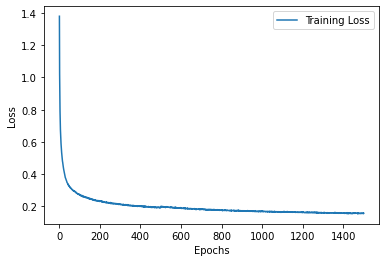

In [102]:

plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Also the weight from a neural network could be saved to file and loaded again if neccesary.

In [103]:
# Save the weights of tf model
model.save_weights('weight_1500epochs')

# Create a new model instance
#model = create_model()

# Restore the weights
#model.load_weights('./checkpoints/my_checkpoint')


In [104]:
# Make final prediction tensoflow dnn
y_submit = model.predict(df_test)
    
#convert propabilities to the maximum confident value
y_submit = np.argmax(y_submit, axis=1)

## Prepare submission

In [ ]:
# encode original labels
y_submit = enc.inverse_transform(y_submit)

In [ ]:
# create dataframe
y_submit = pd.DataFrame(y_submit)

# rename columns
y_submit.columns = ["target"]

y_submit.head()

In [ ]:
# Create submission

# Add "row_id" from testset
submission=pd.concat([df_subm['row_id'],y_submit],axis=1)

# Write submission file
submission.to_csv("submission.csv",index=False)

## Conclusion

First of all I learned a lot during this project. Beside the theoretical part covered during the course espacially here the computational performance was a big issue.

The dataset as well as the models where large compared to what we did during the course and the technics to take care of these topics were verry interesting and sometimes challanging.

My goal was to dig a littee deeper in area of randmo forrest calssifiers and try hands on the one vs all classifier with SVM wich was onyl covered theoretical during course. Also I would brush up my neural network skills a bit.

At the end my first approach with the random forrest lead to the best performace on this dataset. On the real testset on Kaggle I was able to archive a accuracy of 0.97736 which brought me into top 30%.

There is still a lot of room for improvement and to push the accuracy further but I would make a intermediate break here to be able to submit the project for review.

The supremacy of random forrest over SVM was not surprising for me on such a big dataset. But I hoped to be able to outperform the random forrest with the neural network. But in this case my models where either not complex enough to beat the forrest or wherer overfitting.

More data preprocessing and/or postprocessing could probably lead to further improvements. 